In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.mixed_precision import experimental as mixed_precision

from tensorflow.keras.callbacks import Callback

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
BATCH_SIZE = 16
IMG_HEIGHT = 512
IMG_WIDTH = 512
epochs = 40
lr = 3e-4

In [5]:
val_data_dir = '/opt/AIStorage/PLAYGROUND/data/validation'
val_data_dir = pathlib.Path(val_data_dir)

data_dir = '/opt/AIStorage/PLAYGROUND/data/train'
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

3196

In [7]:
val_image_count = len(list(val_data_dir.glob('*/*.png')))
val_image_count

798

In [8]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

val_list_ds = tf.data.Dataset.list_files(str(val_data_dir/'*/*'))

In [9]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  label = -1
  if parts[-2] == 'negative':
    label = tf.constant([1.0, 0.0])
  else:
    label = tf.constant([0.0, 1.0])
  return label

In [10]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [11]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [12]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.ceil(val_image_count/BATCH_SIZE)

In [14]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (512, 512, 3)
Label:  [0. 1.]


In [15]:
for image, label in val_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (512, 512, 3)
Label:  [0. 1.]


In [16]:
def prepare_for_training(ds, shuffle=True, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  if shuffle:
    ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [17]:
train_ds = prepare_for_training(labeled_ds)

valid_ds = prepare_for_training(val_labeled_ds, shuffle=False)
#valid_ds = val_labeled_ds

image_batch, label_batch = next(iter(train_ds))

In [22]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      
      plt.axis('off')

InvalidArgumentError: slice index 16 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

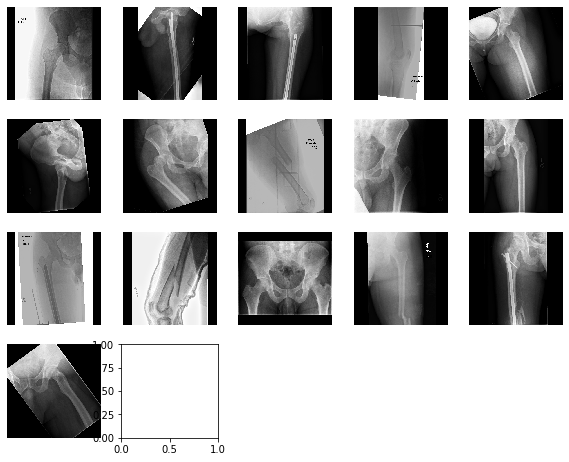

In [21]:
show_batch(image_batch, label_batch)

In [18]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with mirrored_strategy.scope():

    optimizer = tf.keras.optimizers.SGD(lr=lr)
    #optimizer = tf.keras.optimizers.RMSprop(lr=lr)
    #optimizer = tf.keras.optimizers.Adam()
    IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
    base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = False
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    batch_norm_1 = tf.keras.layers.BatchNormalization()
    drop_out_1 = tf.keras.layers.Dropout(0.5)
    dense_layer_1 = tf.keras.layers.Dense(1024,activation='relu')

    batch_norm_2 = tf.keras.layers.BatchNormalization()
    drop_out_2 = tf.keras.layers.Dropout(0.25)
    prediction_layer = tf.keras.layers.Dense(2)

    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      
      batch_norm_1,
      drop_out_1,
      dense_layer_1,
      
      batch_norm_2,
      drop_out_2,
      prediction_layer
    ])

    
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])
    
    model.summary()
    
    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=valid_ds, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH
                    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

Epoch 38/40
200/200 [==============================] - 25s 125ms/step - loss: 0.6879 - acc: 0.6436 - val_loss: 0.7615 - val_acc: 0.6525
Epoch 39/40
200/200 [==============================] - 25s 127ms/step - loss: 0.6814 - acc: 0.6341 - val_loss: 0.7591 - val_acc: 0.6500
Epoch 40/40
200/200 [==============================] - 25s 125ms/step - loss: 0.6779 - acc: 0.6388 - val_loss: 0.7648 - val_acc: 0.6475


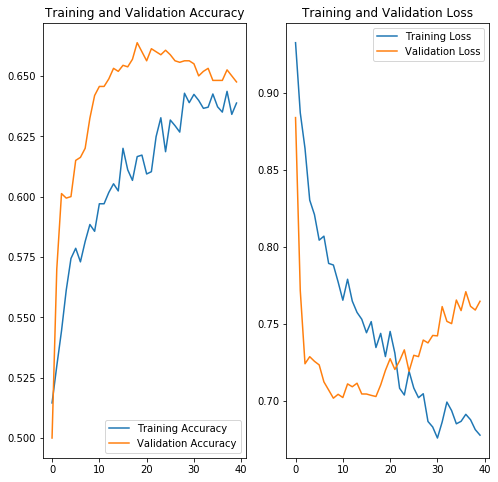

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()